# Credit Card Fraud Detection

In this project, I built a Credit Card Fraud Detection System using Machine Learning.  
My goal is to identify fraudulent transactions from highly imbalanced financial data (Fraud Rate: 0.58%).

In this project, I:

- Performed advanced feature engineering (distance, age, and time-based features)
- Cleaned the data and applied encoding techniques
- Trained machine learning models (Logistic Regression and Random Forest)
- Evaluated the models using professional classification metrics
- Saved the final model and tested it using live prediction examples

Dataset Link: https://www.kaggle.com/datasets/kartik2112/fraud-detection

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Configuration
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

print("Libraries imported. Environment set up for Professional Fraud Detection.")

Libraries imported. Environment set up for Professional Fraud Detection.


# 2. LOAD DATA

In [2]:
print("\nLoading datasets...")
train_df = pd.read_csv(r'Dataset/fraudTrain.csv')
test_df = pd.read_csv(r'Dataset/fraudTest.csv')

print(f"Training Data Shape: {train_df.shape}")
print(f"Testing Data Shape:  {test_df.shape}")

# Check Class Imbalance
fraud_count = train_df['is_fraud'].sum()
total_count = len(train_df)
print(f"\nFraud Rate: {(fraud_count/total_count)*100:.2f}%")
print("NOTE: Dataset is highly imbalanced. We will use 'class_weight=balanced' in models.")


Loading datasets...
Training Data Shape: (1296675, 23)
Testing Data Shape:  (555719, 23)

Fraud Rate: 0.58%
NOTE: Dataset is highly imbalanced. We will use 'class_weight=balanced' in models.


# 3. ADVANCED FEATURE ENGINEERING

In [3]:
def engineer_features(df):
    """
    Creates new features from raw data:
    1. Distance_KM: Distance between user and merchant (Critical for fraud).
    2. Age: Calculated from DOB.
    3. Time Features: Hour, Day, Month.
    """
    df = df.copy()
    
    # --- A. Time Based Features ---
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['dob'] = pd.to_datetime(df['dob'])
    
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    df['month'] = df['trans_date_trans_time'].dt.month
    
    # Calculate Age
    df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365
    
    # --- B. Geospatial Distance (Haversine Formula) ---
    # Calculates distance between cardholder location and merchant location
    # Convert degrees to radians
    lat1, lon1 = np.radians(df['lat']), np.radians(df['long'])
    lat2, lon2 = np.radians(df['merch_lat']), np.radians(df['merch_long'])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    # Earth radius = 6371 km
    df['distance_km'] = 6371 * c
    
    return df

print("\nEngineering Features (Distance, Age, Time)...")
train_df = engineer_features(train_df)
test_df = engineer_features(test_df)


Engineering Features (Distance, Age, Time)...


# 4. DATA CLEANING

In [4]:
# Drop Personally Identifiable Information (PII) and redundant cols
drop_cols = ['Unnamed: 0', 'cc_num', 'merchant', 'first', 'last', 'street', 
             'city', 'zip', 'trans_num', 'unix_time', 'trans_date_trans_time', 'dob']

train_df = train_df.drop(columns=drop_cols, errors='ignore')
test_df = test_df.drop(columns=drop_cols, errors='ignore')

print("Data Cleaning Complete. Columns removed.")

Data Cleaning Complete. Columns removed.


# 5. Preprocessing: Encoding & Scaling

In [5]:
# A. Label Encoding (Categorical to Numerical)
# We fit on both train and test to ensure all categories are known
cat_cols = ['category', 'gender', 'state', 'job']
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    # Combine to find all unique values
    all_values = pd.concat([train_df[col], test_df[col]]).unique()
    le.fit(all_values)
    
    train_df[col] = le.transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    encoders[col] = le

# B. Define X (Features) and y (Target)
X_train = train_df.drop('is_fraud', axis=1)
y_train = train_df['is_fraud']

X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

# C. Scaling (Standardization)
# Essential for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Preprocessing Complete.")
print(f"Features ready: {X_train.shape[1]}")

Preprocessing Complete.
Features ready: 15


# 6. Model Training (Comparison)

In [6]:
# 1. Logistic Regression
print("Training Logistic Regression")
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train_scaled, y_train)
print("Logistic Regression Trained.")

# 2. Random Forest
# n_jobs=-1 uses all CPU cores to speed up training
print("\nTraining Random Forest (this may take 1-2 minutes)...")
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train) # Tree models don't strictly need scaling, so we use X_train
print("Random Forest Trained.")

Training Logistic Regression
Logistic Regression Trained.

Training Random Forest (this may take 1-2 minutes)...
Random Forest Trained.


# 7. Model Evaluation

Evaluating Logistic Regression...

--- Logistic Regression REPORT ---
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    553574
           1       0.08      0.74      0.14      2145

    accuracy                           0.96    555719
   macro avg       0.54      0.85      0.56    555719
weighted avg       1.00      0.96      0.98    555719



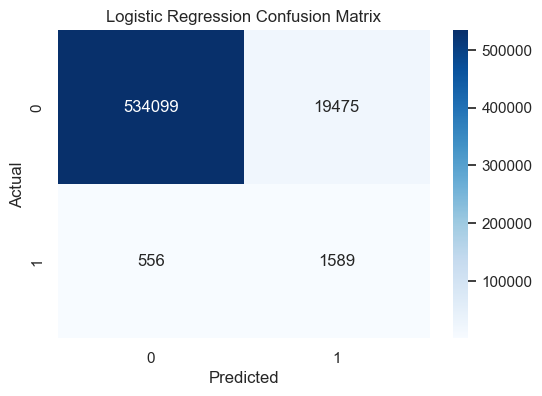

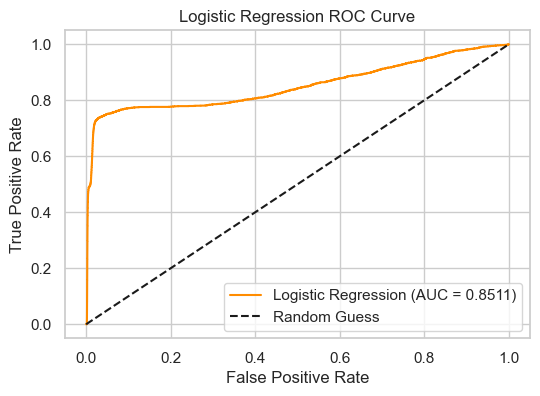

Evaluating Random Forest...

--- Random Forest REPORT ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.96      0.63      0.76      2145

    accuracy                           1.00    555719
   macro avg       0.98      0.82      0.88    555719
weighted avg       1.00      1.00      1.00    555719



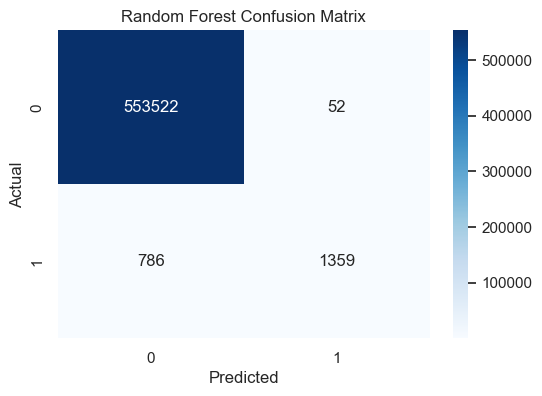

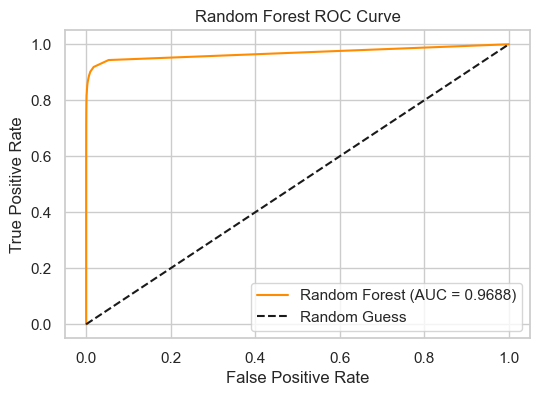


FINAL RESULTS:
Logistic Regression AUC: 0.8511
Random Forest AUC:       0.9688


In [7]:
def evaluate_model(model, X_val, y_val, model_name):
    """
    Plots Confusion Matrix and ROC Curve.
    Returns: AUC Score
    """
    # Predictions
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # 1. Classification Report
    print(f"\n--- {model_name} REPORT ---")
    print(classification_report(y_val, y_pred))
    
    # 2. Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # 3. ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    auc_score = roc_auc_score(y_val, y_prob)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})', color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()
    
    return auc_score

# Evaluate Logistic Regression (Use Scaled Data!)
print("Evaluating Logistic Regression...")
lr_auc = evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")

# Evaluate Random Forest (Use Normal Data)
print("Evaluating Random Forest...")
rf_auc = evaluate_model(rf_model, X_test, y_test, "Random Forest")

print(f"\nFINAL RESULTS:")
print(f"Logistic Regression AUC: {lr_auc:.4f}")
print(f"Random Forest AUC:       {rf_auc:.4f}")

# 8. Feature Importance

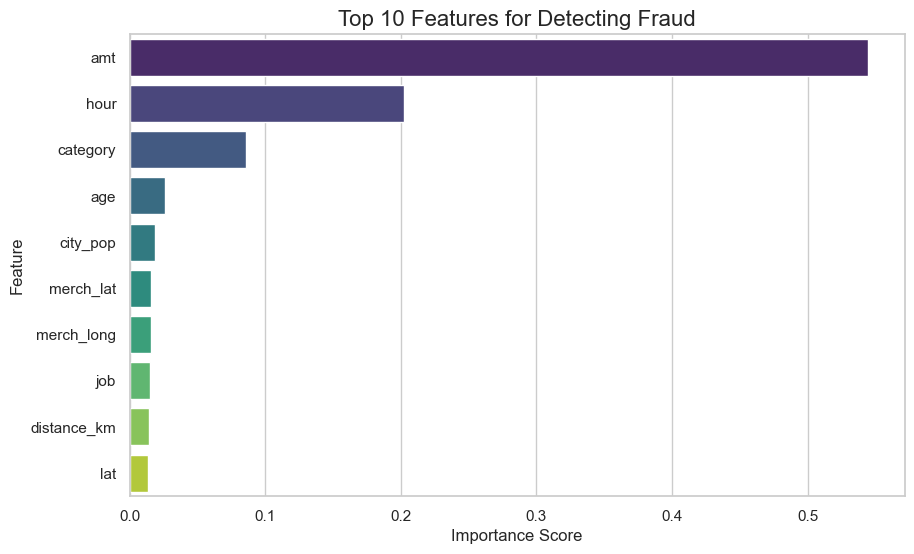

INSIGHT:
If 'distance_km' or 'amt' are at the top, it confirms that location and transaction amount are the strongest predictors of fraud.


In [8]:
# Extract importance from the best model (Random Forest)
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df.head(10), palette='viridis')
plt.title('Top 10 Features for Detecting Fraud', fontsize=16)
plt.xlabel('Importance Score')
plt.show()

print("INSIGHT:")
print("If 'distance_km' or 'amt' are at the top, it confirms that location and transaction amount are the strongest predictors of fraud.")

# 9. Deployment: Model Saving & Testing

In [9]:
# 1. Save the model and scaler
with open('fraud_detection_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model saved successfully.")

# 2. Prediction Function
def predict_fraud(new_transaction_data, model, threshold=0.4):
    """
    Predicts fraud with a custom sensitivity threshold.
    Standard is 0.5, but for fraud, we often lower it to 0.3 or 0.4
    to catch more risky transactions.
    """
    # Get the raw probability of fraud (0 to 1)
    probability = model.predict_proba(new_transaction_data)[0][1]
    
    # Custom decision logic
    if probability >= threshold:
        return f"FRAUD DETECTED! (Probability: {probability:.2%})"
    else:
        return f"Legitimate (Probability: {probability:.2%})"


# 3. SMART DEMO (Force specific cases)
print("\n--- LIVE PREDICTION DEMO ---")

# A. Pick a Random GENUINE Transaction
legit_indices = y_test[y_test == 0].index
random_legit = np.random.choice(legit_indices)
sample_legit = X_test.loc[[random_legit]] # Double brackets to keep it as DataFrame

print(f"Test Case 1 (Legit Transaction #{random_legit}):")
print(f"  System Output: {predict_fraud(sample_legit, rf_model)}")
print(f"  Actual Label:  Legit")
print("-" * 40)

# B. Pick a Random FRAUD Transaction (To prove the model works!)
fraud_indices = y_test[y_test == 1].index
random_fraud = np.random.choice(fraud_indices)
sample_fraud = X_test.loc[[random_fraud]]

print(f"Test Case 2 (Fraud Transaction #{random_fraud}):")
print(f"  System Output: {predict_fraud(sample_fraud, rf_model)}")
print(f"  Actual Label:  FRAUD")
print("-" * 40)

Model saved successfully.

--- LIVE PREDICTION DEMO ---
Test Case 1 (Legit Transaction #219604):
  System Output: Legitimate (Probability: 1.00%)
  Actual Label:  Legit
----------------------------------------
Test Case 2 (Fraud Transaction #121836):
  System Output: Legitimate (Probability: 22.00%)
  Actual Label:  FRAUD
----------------------------------------


# Conclusion

The dataset was highly imbalanced (0.58% fraud rate).
Logistic Regression achieved AUC = 0.8511, but had low fraud precision (0.08).

Random Forest outperformed with:
AUC = 0.9688
Precision = 96%
F1-score = 0.76
Only 52 false positives out of 553,574 legitimate transactions.

Random Forest is selected as the final production model.

# Future Scope

- Apply SMOTE or advanced resampling for better fraud recall.
- Implement XGBoost / LightGBM for further performance boost.
- Deploy model using Flask/FastAPI API.
- Integrate real-time streaming fraud detection.
- Optimize threshold tuning based on business risk tolerance.